# Quantum mechanical data assimilation of the Lorenz 96 multiscale model

In this notebook, we perform quantum mechanical data assimilation (QMDA) of the Lorenz L96 (L96) multiscale system with a simulated quantum circuit implemented in the Qiskit Aer library. The notebook reproduces the quantum circuit results in Figs. 6 and 7 of Freeman et al. (2023), "Data assimilation in operator algebras", *PNAS*, [doi:10.1073/pnas.2211115](https://dx.doi.org/10.1073/pnas.2211115). Running the notebook requires installation of the NLSA package provided in the directory `/Python` of the repository. See `/Python/README.md` for installation instructions. 

The notebook makes use of output generated from the MATLAB script `l96Multiscale_qmda.m` in this directory. `l96Multiscale_qmda` generates training and test data and computes data-driven basis functions using the MATLAB NLSA code. Using the basis, it computes the matrix representation of the Koopman operator, multiplication operator representing the forecast observable, and the matrix-valued feature map which are used by the quantum circuit implementation in this notebook. The NLSA and QMDA parameters used in the notebook must therefore match the corresponding parameters used in the MATLAB code.

In [1]:
%load_ext nb_mypy
%nb_mypy Off
    
%matplotlib ipympl

Version 1.0.4


In [2]:
import matplotlib.pyplot as plt
import nlsa.function_algebra as fun
import nlsa.matrix_algebra as mat
import nlsa.vector_algebra as vec
import numpy as np
import scipy.linalg as la

from dataclasses import dataclass
from functools import partial
from ipywidgets import interact, IntSlider
from itertools import islice
from mat73 import loadmat
from more_itertools import take
from multiprocess import Pool
from nlsa.abstract_algebra import id_map, iterate, multiply_by
from nlsa.dynamics import cocycle_orbit
from nlsa.function_algebra import compose, compose2
from nlsa.qmda import make_da, pure_state_prediction, Qmda
from nlsa.quantum_circuits import ensemble_measurement, koopman_circuit
from os.path import join
from typing import TypeVar
from nptyping import Int, NDArray, Shape

## Data preparation

First, we read in the matrix representations of the Koopman operator (`u`), multiplication operator for the forecast observable (`m`), operator-valued feature map at the observed data (`k`), and true values of the forecast observable (`y`). Note that we pass the Koopman operator matrix `u` through the polar decomposition in order to produce a unitary evolution matrix as required by a closed quantum circuit. We also compute an eigendecomposition of the observable matrix `m` which is needed to compute forecast probability distributions. 

In [3]:
@dataclass
class Nlsa:
    """Class for keeping track of NLSA parameters for L96 multiscale system.
    
    """
    # Parameters to be set by user
    F: float # Forcing parameter
    epsilon: float # Timesscale parameter for fast variables
    dt: float # Sampling interval
    nS: int # Number of training samples
    nSOut: int # Number of test samples
    idxXSrc: NDArray[Shape["NX"], Int] # State vector components to use for training 
    idxXObs: NDArray[Shape["NXO"], Int] # State vector components for observations
    embWindow: int # Delay embedding window
    kernel: str # Kernel type
    ifDen: bool # Set true to use variable-bandwidth kernel  
    
    # Parameters with default values
    nX: int = 9 # slow variables
    nY: int = 8 # fast variables
    hX: float = -0.8 # Coupling parameter from slow to fast variables
    hY: float = 1.0 # Coupling parameter from fast to slow variables    
    nSSpin: int = 10000 # Number of spinup samples
    x0: float  = 1     # Initial conditions for slow variables (training data)
    y0: float  = 1     # Initial conditions for fast variables (training data)
    x0Out: float = 1.2  # Initial conditions for slow variables (test data)
    y0Out: float = 1.2  # Initial conditions for fast variables (test data)
    absTol: float = 1E-7 # Absolute tolerance for ODE solver
    relTol: float = 1E-5 # Relative tolerance for ODE solver
        
    
    def tag(self) -> str:
        s = f'F{self.F:.1f}'\
          + f'_eps{self.epsilon:.3g}'\
          + f'_dt{self.dt:.2g}'\
          + f'_nS{self.nS}'\
          + f'_nSOut{self.nSOut}'\
          + f'_idxXSrc1-+1-{self.idxXSrc[-1]}'\
          + f'_idxXObs1-+1-{self.idxXObs[-1]}'\
          + f'_emb{self.embWindow}'\
          + '_' + self.kernel
        if self.ifDen:
            s += '_den'
        return s

In [4]:
# Set up NLSA and QMDA parameters
nlsa_model = Nlsa(F=10,
                  epsilon=1 / 128,
                  dt=0.05,
                  nS=40000,
                  nSOut=7000,
                  idxXSrc=np.arange(1, 9 + 1),
                  idxXObs=np.arange(1, 9 + 1),
                  embWindow=1,
                  kernel='l2',
                  ifDen=True)

qmda_model = Qmda(nTO=1, # number of timesteps per assimilated observation
                  nTF=100, # number of forecast timesteps
                  nL=1024, # number of basis functions
                  shape_fun="bump", # kernel shape function used in state update
                  epsilon=0.6) # bandwidth scaling parameter

q = 10 # number of qubits
n_obs = 200 # number of data assimilation observations
n_pred = 100 # number of prediction timesteps
n = 2 ** q # QMDA Hilbert space dimension

In [5]:
# Import data from MATLAB code
path = './figs'
path = join(path, nlsa_model.tag(), qmda_model.tag())

qmda_data = \
    {'u': loadmat(join(path, 'u.mat'), only_include='U_sav')['U_sav'],
     'm': loadmat(join(path, 'm.mat'), only_include='M')['M'],
     'm_eval': loadmat(join(path, 'm.mat'), only_include='MEval')['MEval'],
     'm_evec': loadmat(join(path, 'm.mat'), only_include='MEvec')['MEvec'],
     'k': loadmat(join(path, 'k.mat'), only_include='K_sav')['K_sav'],
     'y': loadmat(join(path, 'y.mat'), only_include='yRef')['yRef']
    }

In [6]:
u, _ = la.polar(qmda_data['u'][0:n, 0:n, 0])  # unitary Koopman matrix
m = qmda_data['m'][0:n, 0:n] # multiplication operator matrix
k = np.swapaxes(qmda_data['k'][0:n, 0:n, 0:n_obs], -1, 0) # array of feature operators
y = qmda_data['y'][0:n_pred, 0:n_obs].T # reference trajectory

In [7]:
m_eval, m_evec = mat.eig_sorted(m, which='SR') # multiplication operator eigenvalues
m_evec, _ = la.polar(m_evec) # multiplication operator eigenvectors
dy = np.empty(n) # spectral bin sizes
dy[1:-1] = (m_eval[2:] - m_eval[:-2]) / 2
dy[0] = dy[1]
dy[-1] = dy[-2]

## Posterior states

We compute the quantum mechanical state vectors immediately after each observation by classical computation. For that, we build the transfer operator `transfer_op` that advances the state vector as a multiplication operator by the adjoint of the Koopman operator matrix `u`. We also buiild a Bayesian state update function `bayes` that conditions the state vector by the matrix representing the operator-valued feature map at each observation. Together `transfer_op` and `bayes` define a non-autonomous (skew-product) dynamical system that evolves an initial state vector `xi` given a sequence of feature matrices `k`. This evolution is stored in an array `xi_da`.

In [8]:
xi = np.concatenate((np.array([1]), np.zeros(n - 1)))

transfer_mat = u.conj().T
transfer_op = multiply_by(mat, transfer_mat)
bayes = partial(vec.condition_by, mat)
da = make_da(forecast=transfer_op, analysis=bayes)
xi_da = take(n_obs, cocycle_orbit(xi, k, da))

## Quantum circuit construction

We build quantum a circuit `circ` that implements Koopman evolution of the forecast observable given an initial state vector using the `koopman_circuit` function from the `nlsa.quantum_circuits` module. This function uses the `QuantumCircuit` class from Qiskit to build the circuit as composition of unitary gates that perform state initialization, Koopoman evolution, and eigenbasis rotation to produce probabilistic forecasts of the observable through measurement in the quantum computational purposes. The circuit created here is used for illustrative purposes only (Fig. 6 in Freeman et al.), and will be replaced by a family of circuits for each initial condition in `xi_da` below.    

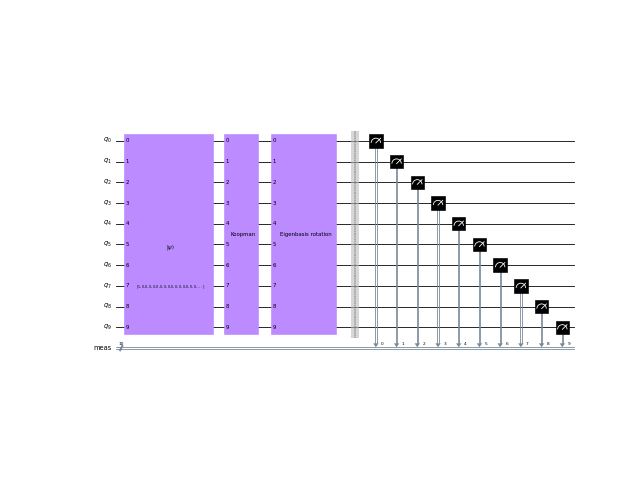

In [9]:
circ = koopman_circuit(q, m_evec, transfer_mat, xi)

i_fig = 1

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax.cla()
circ.draw(output='mpl', ax=ax)
circ.draw(output='latex_source', filename='koopman_circuit.tex');

## Quantum circuit forecasts

In the followingm, we fix a reference time in the verification dataset corresponding to timestep `j_ver`, and we build quantum circuits that predict the value of the forecast observable at the verification time at lead times of up to `max_lead` timestep at increments of `step_lead`. The initial quantum states come from the posterior states in `q_da`. We make probabilistic forecasts by forming ensembles of quantum measurements for each of these circuits. The number of ensemble members (shots) in each ensemble is specified by the variable `n_shots`. We form empirical forecast probability histograms and compare the forecast mean against the true value of the observable. These results correspond to Fig. 7 of Freeman et al.  

In [10]:
n_proc = 2 # number of parallel processes
pl = Pool(n_proc)

In [11]:
j_ver = 150 # forecast verification timesetp
max_lead = 15
step_lead = 5

j_lead = np.arange(0, max_lead + 1, step_lead)
n_lead = len(j_lead)
y_true = y[j_ver - 1, 0]

In [12]:
predict_with_expectation = partial(pure_state_prediction, mat, m)

transfer_mats = iterate(mat, transfer_mat, initial=np.identity(n)) 
xis = (xi_da[j_ver - j] for j in j_lead)
exp_result = pl.starmap(predict_with_expectation, 
                        zip(islice(transfer_mats, 0, max_lead + 1, step_lead), 
                            xis))

In [13]:
n_shots = 1E6

make_circuit = partial(koopman_circuit, q, m_evec)
make_measurement = partial(ensemble_measurement, shots=n_shots)
predict_with_circuit = compose2(make_measurement, make_circuit)

transfer_mats = iterate(mat, transfer_mat, initial=np.identity(n)) 
xis = (xi_da[j_ver - j] for j in j_lead)
circ_pred = map(predict_with_circuit, 
                islice(transfer_mats, 0, max_lead + 1, step_lead), xis)
circ_result = take(n_lead, circ_pred)

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=3), Output()), _dom_cla…

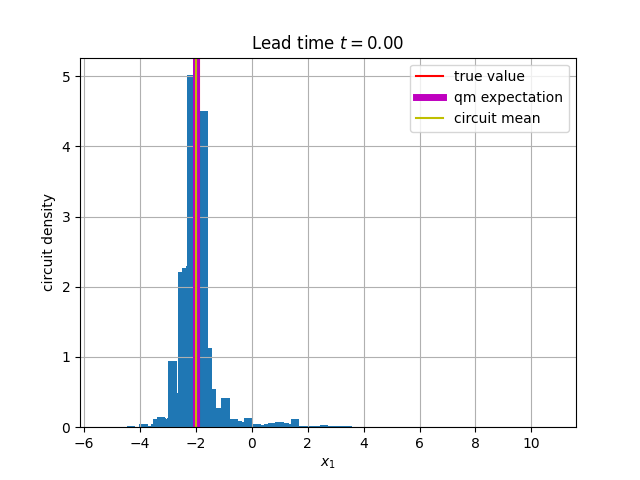

In [14]:
# Interactive histogram plots as a function of lead time
i_fig = 2

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)

i_slider = IntSlider(value=0, min=0, max=n_lead - 1, continuous_update=False)

@interact(i=i_slider) 
def plot_result(i):
    idx = circ_result[i][0]
    density = circ_result[i][1]
    density_dy = density / dy[idx]
    circ_mean = np.sum(m_eval[idx] * density)
    ax.cla()
    ax.axvline(x=y_true, color='r', label="true value")
    ax.axvline(x=exp_result[i], color='m', linewidth=5, label="qm expectation")
    ax.axvline(x=circ_mean, color='y', label="circuit mean")
    ax.bar(m_eval[idx], density_dy, width=0.3)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("circuit density")
    ax.set_title(f"Lead time $t={j_lead[i] * nlsa_model.dt:.2f}$")
    ax.legend()
    ax.grid()

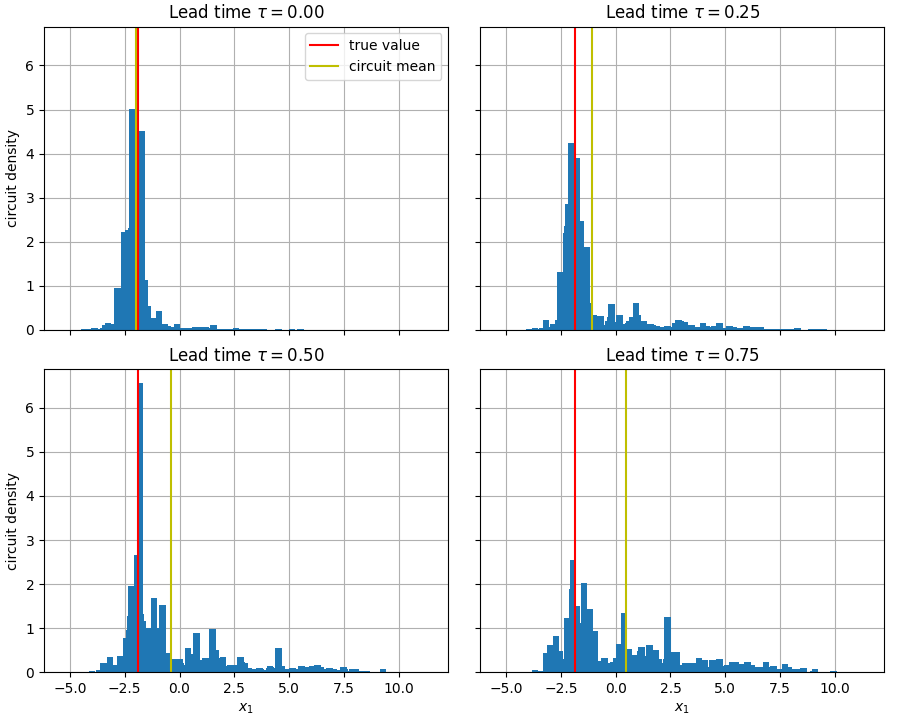

In [15]:
# Tiled histogram plots
i_fig = 3

if plt.fignum_exists(i_fig):
    plt.close(i_fig)

fig, axs = plt.subplots(2, 2, figsize=(9, 7.2), subplot_kw=dict(box_aspect=0.75), 
                        num=i_fig, sharex=True, sharey=True,
                        constrained_layout=True)

for i, ax in enumerate(axs.flatten()):
    idx = circ_result[i][0]
    density = circ_result[i][1]
    density_dy = density / dy[idx]
    circ_mean = np.sum(m_eval[idx] * density)
    #print(circ_mean)
    ax.cla()
    ax.axvline(x=y_true, color='r', linewidth=1.5, label="true value")
    ax.axvline(x=circ_mean, color='y', linewidth=1.5, label="circuit mean")
    ax.bar(m_eval[idx], density_dy, width=0.3)
    ax.set_axisbelow(True)
    ax.set_title(f"Lead time $\\tau={j_lead[i] * nlsa_model.dt:.2f}$")
    ax.grid()
    
axs[0, 0].legend()

for ax in axs[:, 0]:
    ax.set_ylabel("circuit density")
    
for ax in axs[-1, :]:
    ax.set_xlabel("$x_1$")
    
plt.savefig('figCircuitPred.png', format='png', dpi=300)